
# SGT-Sequence Embedding for Clustering, Classification, and Search

## Illustrative examples

In [1]:
from sgt import SGT
# sgt.__version__
import numpy as np
import pandas as pd
from itertools import chain
from itertools import product as iterproduct
import warnings

import pickle

########
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(7) # fix random seed for reproducibility

# from sgt import Sgt

c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 0. YJ Load Data

In [2]:
YJPATH3 = r'F:/YJ-format-230125/data/'; OUTDIR3 = r'interim/'
df = pd.read_csv(YJPATH3 + OUTDIR3 + r'pbp-zone-2023-03-20.csv', encoding='cp949', low_memory=False)
df = df.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
def one_digit(n): return f"{n:.0f}"
def two_digit(n): return f"{n:02d}"
def three_digit(n): return f"{n:03d}"
def six_digit(n): return f"{n:06d}"
df['zone101_new']=df['zone101_new'].apply(two_digit)
df['bs_cnt']=df['bs_cnt'].apply(two_digit)
df['bso_cnt']=df['bso_cnt'].apply(three_digit)
df['bso_rcnt']=df['bso_rcnt'].apply(six_digit)
pit_len = df.groupby(['gid-intot-panum']).agg(pit_len=('pitch_number','last')).reset_index()
dfdf = pd.merge(df, pit_len, on='gid-intot-panum', how='left')

dfdf['pa_cate_en1'] = dfdf['pa_cate_en1'].bfill()
dfdf['pa_cate_en2'] = dfdf['pa_cate_en2'].bfill()
dfdf['pa_cate_en3'] = dfdf['pa_cate_en3'].bfill()
dfdf['pa_out_yns'] = dfdf['pa_out_yns'].bfill()
dfdf['pa_out_ynn'] = dfdf['pa_out_ynn'].bfill()
dfdf['pa_bip_out'] = dfdf['pa_cate_en1']+'_'+dfdf['pa_out_yns']
dfdf['gid-intot-panum-cid'] = dfdf['gid-intot-panum']+'-'+dfdf['cid']
cf=dfdf[(dfdf['pit_len']>=3)][['cid', 'game_date', 'gid-intot-panum-cid', 'gid-intot-panum', 'pitch_type', 'pitch_type_en', 'pitch_type_le', 'pitch_number', 'bs_cnt', 'bso_cnt', 'pit_len', 'pa_bip_out', 'pa_out_yns', 'pa_cate_en1', 'pa_cate_en2']]

# cf["game_date"] = pd.to_datetime(cf.game_date, format='%Y-%m-%d')
# data = cf[['gid-intot-panum-cid', 'pitch_type']].copy()

In [3]:
cf=dfdf[(dfdf['pit_len']>=3)][['cid', 'game_date', 'gid-intot-panum-cid', 'gid-intot-panum', 'pitch_type', 'pitch_type_en', 'pitch_type_le', 'pitch_number', 'bs_cnt', 'bso_cnt', 'pit_len', 'pa_bip_out', 'pa_out_yns', 'pa_cate_en1', 'pa_cate_en2']]

In [14]:
dfdf.groupby(['pitch_type_en', 'pitch_type'])[['gid-intot-panum-pitnum']].nunique().reset_index().T

,0,1,2,3,4,5,6,7,8
pitch_type_en,C,F,K,L,O,S,T,T,U
pitch_type,체인,직구,너클,슬라,포크,싱커,커터,투심,커브
gid-intot-panum-pitnum,134669,587378,1219,242405,84873,170,31741,100644,125122


In [4]:
dfdf.groupby(['pa_cate_en1','pa_out_ynn', 'pa_out_yns','pa_cate_en2','pa_cate_en3','pa_result'])[['gid-intot-panum']].nunique().reset_index()

,pa_cate_en1,pa_out_ynn,pa_out_yns,pa_cate_en2,pa_cate_en3,pa_result,gid-intot-panum
0,BIP,0.0,NO OUT,HBIP,ON1B,내야안타,5289
1,BIP,0.0,NO OUT,HBIP,ON1B,번트 안타,791
2,BIP,0.0,NO OUT,HBIP,ON1B,안타,51358
3,BIP,0.0,NO OUT,HBIP,ON2B,2루타,14215
4,BIP,0.0,NO OUT,HBIP,ON3B,3루타,1182
5,BIP,1.0,OUT,OUT,AO,희생플라이,2758
6,BIP,1.0,OUT,OUT,GO,필드 아웃,77111
7,BIP,1.0,OUT,OUT,GO,희생번트,2985
8,BIP,1.0,OUT,OUT,Other,병살타,6714
9,BIP,1.0,OUT,OUT,Other,삼중살,10


In [10]:
cf['cid'].unique()

array(['양의지-76232', '조인성-98144', '차일목-73602', '이지영-79456', '이홍구-63634',
       '한승택-63722', '이재원-76812', '이해창-60343', '박동원-79365', '정상호-71842',
       '김재현-62332', '김태군-78122', '강민호-74540', '최경철-73824', '유강남-61102',
       '박세혁-62244', '최재훈-78288', '장성우-78548', '김민식-62864', '박대온-64944',
       '김사훈-61591', '신성현-64086', '강태율-65514', '권정웅-65412', '윤요섭-78892',
       '주효상-66354', '이정훈-67644', '나원탁-67454', '허도환-77243', '김태우-62927',
       '로사리오-66740', '박상언-66707', '조윤준-62147', '김종민-79364', '나주환-73209',
       '이성우-71184', '나종덕-67539', '박유연-67202', '백용환-78643', '정범모-76720',
       '김만수-65044', '김민수-64793', '신진호-67944', '김지수-79300', '지시완-64717',
       '장승현-63202', '강진성-62925', '이성열-73136', '이준수-77654', '김응민-60288',
       '윤수강-62537', '김형준-68912', '신범수-66662', '안중열-64022', '김창혁-60184',
       '김기연-66112', '김종덕-66392', '이흥련-63440', '김준태-62558', '노시환-69737',
       '강백호-68050', '김도환-69442', '베탄코트-69950', '신용수-69508', '전준호-67123',
       '안승한-64011', '이현석-65869', '한준수-68646', '정보근-68518', '김재

In [77]:
data = cf[cf['cid']=='박세혁-62244'][['gid-intot-panum-cid', 'pitch_type', 'pitch_type_en', 'pitch_type_le', 'pa_cate_en1', 'pa_out_yns', 'pitch_number']].copy()
data['sequence'] = data['pitch_type'].replace({'직구':'직', '슬라':'슬', '체인':'체', '포크':'포', '커브':'커', '커터':'터', '투심':'투', '너클':'너', '싱커':'싱'},regex=True)
data['id'] = data['gid-intot-panum-cid']

input_data = data[['id', 'sequence', 'pitch_type_le', 'pitch_type_en', 'pa_out_yns', 'pitch_number']].copy()
input_data = input_data.groupby(['id']).agg(pa_out_yns=('pa_out_yns','last'), sequence=('sequence', lambda x:list(x))
                                            , sequence_en=('pitch_type_en', lambda x:list(x)), sequences=('pitch_type_le', lambda x:list(x))
                                                          ,pitch_number= ('pitch_number',lambda x:list(x))).reset_index()
input_data['seqlen'] = input_data['sequence'].astype(str).str.split(',', expand=False).agg([len])
input_data = input_data[input_data['seqlen']>2].reset_index(drop=True)
input_data['sequences'] = input_data['sequences'].agg(lambda x: '~'.join(map(str, x)))
input_data

,id,pa_out_yns,sequence,sequence_en,sequences,pitch_number,seqlen
0,20170402HHOB02017-081-61-박세혁-62244,OUT,"[커, 직, 직, 직, 직]","[U, F, F, F, F]",6~4~4~4~4,"[1, 2, 3, 4, 5]",5
1,20170402HHOB02017-091-70-박세혁-62244,OUT,"[커, 포, 직]","[U, O, F]",6~9~4,"[1, 2, 3]",3
2,20170402HHOB02017-091-71-박세혁-62244,OUT,"[커, 직, 커]","[U, F, U]",6~4~6,"[1, 2, 3]",3
3,20170402HHOB02017-091-73-박세혁-62244,NO OUT,"[직, 포, 직, 포, 포, 직]","[F, O, F, O, O, F]",4~9~4~9~9~4,"[1, 2, 3, 4, 5, 6]",6
4,20170402HHOB02017-091-74-박세혁-62244,OUT,"[커, 직, 포, 직, 포]","[U, F, O, F, O]",6~4~9~4~9,"[1, 2, 3, 4, 5]",5
...,...,...,...,...,...,...,...
13678,20221008WOOB02022-071-46-박세혁-62244,NO OUT,"[직, 체, 체, 직]","[F, C, C, F]",4~5~5~4,"[1, 2, 3, 4]",4
13679,20221008WOOB02022-071-47-박세혁-62244,OUT,"[체, 직, 직, 직]","[C, F, F, F]",5~4~4~4,"[1, 2, 3, 4]",4
13680,20221008WOOB02022-081-52-박세혁-62244,OUT,"[직, 슬, 직, 직, 포, 슬]","[F, L, F, F, O, L]",4~2~4~4~9~2,"[1, 2, 3, 4, 5, 6]",6
13681,20221008WOOB02022-081-53-박세혁-62244,OUT,"[포, 커, 포, 직, 직, 포, 직]","[O, U, O, F, F, O, F]",9~6~9~4~4~9~4,"[1, 2, 3, 4, 5, 6, 7]",7


## 1. Sequence Clustering

In [78]:
corpus = input_data[['id', 'sequence']].copy()
corpus

,id,sequence
0,20170402HHOB02017-081-61-박세혁-62244,"[커, 직, 직, 직, 직]"
1,20170402HHOB02017-091-70-박세혁-62244,"[커, 포, 직]"
2,20170402HHOB02017-091-71-박세혁-62244,"[커, 직, 커]"
3,20170402HHOB02017-091-73-박세혁-62244,"[직, 포, 직, 포, 포, 직]"
4,20170402HHOB02017-091-74-박세혁-62244,"[커, 직, 포, 직, 포]"
...,...,...
13678,20221008WOOB02022-071-46-박세혁-62244,"[직, 체, 체, 직]"
13679,20221008WOOB02022-071-47-박세혁-62244,"[체, 직, 직, 직]"
13680,20221008WOOB02022-081-52-박세혁-62244,"[직, 슬, 직, 직, 포, 슬]"
13681,20221008WOOB02022-081-53-박세혁-62244,"[포, 커, 포, 직, 직, 포, 직]"


## 2. Compute SGT embeddings

In [79]:
%%time
sgt_ = SGT(kappa=1, lengthsensitive=False, mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(corpus)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
CPU times: total: 78.1 ms
Wall time: 2.64 s


In [18]:
sgtembedding_df

,id,"(슬, 슬)","(슬, 싱커)","(슬, 직)","(슬, 체)","(슬, 커)","(슬, 터)","(슬, 투)","(슬, 포)","(싱커, 슬)",...,"(투, 투)","(투, 포)","(포, 슬)","(포, 싱커)","(포, 직)","(포, 체)","(포, 커)","(포, 터)","(포, 투)","(포, 포)"
0,20170402HHOB02017-081-61-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,20170402HHOB02017-091-70-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.367879,0.0,0.000000,0.0,0.0,0.000000
2,20170402HHOB02017-091-71-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,20170402HHOB02017-091-73-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.222352,0.0,0.000000,0.0,0.0,0.184334
4,20170402HHOB02017-091-74-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.367879,0.0,0.000000,0.0,0.0,0.135335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13678,20221008WOOB02022-071-46-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
13679,20221008WOOB02022-071-47-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
13680,20221008WOOB02022-081-52-박세혁-62244,0.018316,0.0,0.251607,0.0,0.0,0.0,0.0,0.049787,0.0,...,0.0,0.0,0.367879,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
13681,20221008WOOB02022-081-53-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.137142,0.0,0.367879,0.0,0.0,0.063953


In [80]:
# Set the id column as the dataframe index
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(슬, 슬)","(슬, 싱)","(슬, 직)","(슬, 체)","(슬, 커)","(슬, 터)","(슬, 투)","(슬, 포)","(싱, 슬)","(싱, 싱)",...,"(투, 투)","(투, 포)","(포, 슬)","(포, 싱)","(포, 직)","(포, 체)","(포, 커)","(포, 터)","(포, 투)","(포, 포)"
id,,,,,,,,,,,,,,,,,,,,,
20170402HHOB02017-081-61-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20170402HHOB02017-091-70-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.367879,0.0,0.000000,0.0,0.0,0.000000
20170402HHOB02017-091-71-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20170402HHOB02017-091-73-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.222352,0.0,0.000000,0.0,0.0,0.184334
20170402HHOB02017-091-74-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.367879,0.0,0.000000,0.0,0.0,0.135335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221008WOOB02022-071-46-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20221008WOOB02022-071-47-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20221008WOOB02022-081-52-박세혁-62244,0.018316,0.0,0.251607,0.0,0.0,0.0,0.0,0.049787,0.0,0.0,...,0.0,0.0,0.367879,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


We perform PCA on the sequence embeddings and then do kmeans clustering.

In [81]:
pca = PCA(n_components=8)
pca.fit(sgtembedding_df)

X=pca.transform(sgtembedding_df)
print(np.sum(pca.explained_variance_ratio_))

0.6243851066547763


In [82]:
pca = PCA(n_components=2)
pca.fit(sgtembedding_df)

X=pca.transform(sgtembedding_df)

print(np.sum(pca.explained_variance_ratio_))
# df = pd.DataFrame(data=X, columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])
df = pd.DataFrame(data=X, columns=['x1','x2'])
df

0.2499501642585994


,x1,x2
0,-0.096040,-0.048515
1,-0.135069,-0.080751
2,-0.151129,0.098264
3,-0.135603,-0.157288
4,-0.190304,-0.257657
...,...,...
13678,-0.156012,0.346732
13679,-0.102560,-0.011029
13680,0.156879,-0.131161
13681,-0.152161,-0.199003


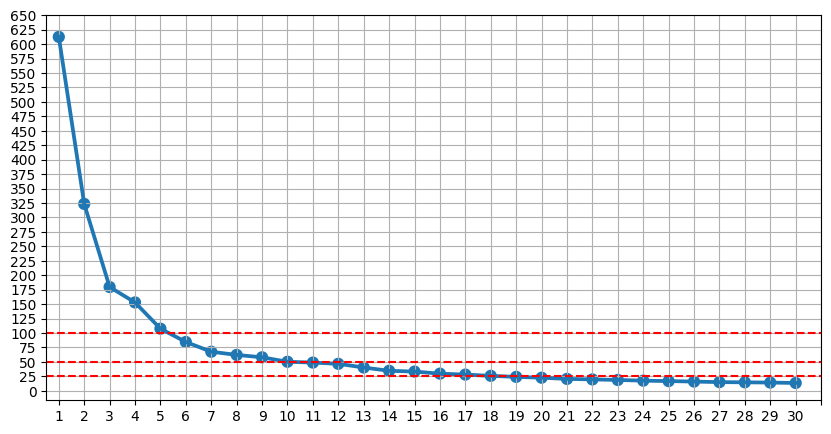

In [83]:
from sklearn.cluster import KMeans
import seaborn as sns
SSE = []
for k in range(0, 30):
    kmeans = KMeans(n_clusters=k+1, random_state=0, n_init="auto").fit(df)
    SSE.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
ax=sns.pointplot(x=list(range(1,31)), y=SSE)
plt.yticks(np.arange(0, 675, 25))
plt.xticks(np.arange(0, 31, 1))
plt.axhline(100, 0, 30, color='red', linestyle='--', linewidth=1.5)
plt.axhline(50, 0, 30, color='red', linestyle='--', linewidth=1.5)
plt.axhline(25, 0, 30, color='red', linestyle='--', linewidth=1.5)
plt.grid()
plt.show()

c:\app\anaconda3\envs\yjformat\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


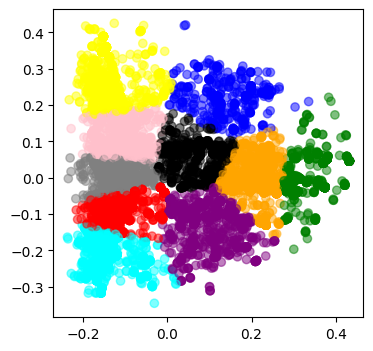

In [52]:
kmeans = KMeans(n_clusters=10, max_iter =2000)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(4, 4))
colmap = {1: 'r', 2: 'orange', 3: 'yellow', 4:'green', 5:'cyan', 6:'blue', 7:'pink', 8:'purple', 9:'gray', 10:'black'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

## 3. Sequence Classification using Deep Learning in TensorFlow

- Sequence Classification
- total of samples = 13352. 
- sequence lengths = 3-19.

In [53]:
y = input_data['pa_out_yns']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

corpus = input_data[['id', 'sequence']].copy()

#### 3.1) Sequence embeddings

In [54]:
# Sequence embedding
sgt_ = SGT(kappa=1, lengthsensitive=False, mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(corpus)
X = sgtembedding_df.set_index('id')

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


#### 3.2) 10-fold cross-validation

In [55]:
kfold = 10
X = X
y = encoded_y

random_state = 1

test_F1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1],))) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=0)
    
    y_pred = model.predict(X_test).round().astype(int)
    y_train_pred = model.predict(X_train).round().astype(int)

    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred) # micro, macro
    k+=1
    
print ('Average f1 score', np.mean(test_F1))

385/385 [==============================] - 0s 864us/step
Average f1 score 0.7969784275062595


In [56]:
print ('Average f1 score', np.mean(test_F1))

Average f1 score 0.7969784275062595


## 4. Classification for Intrusion Detection

In [57]:
y = input_data['pa_out_yns']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

corpus = input_data[['id', 'sequence']].copy()

In [58]:
from collections import Counter
Counter(encoded_y)

Counter({1: 9083, 0: 4600})

In [59]:
# Sequence embedding
sgt_ = SGT(kappa=5, lengthsensitive=True, mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(corpus)
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,"(슬, 슬)","(슬, 싱커)","(슬, 직)","(슬, 체)","(슬, 커)","(슬, 터)","(슬, 투)","(슬, 포)","(싱커, 슬)","(싱커, 싱커)",...,"(투, 투)","(투, 포)","(포, 슬)","(포, 싱커)","(포, 직)","(포, 체)","(포, 커)","(포, 터)","(포, 투)","(포, 포)"
id,,,,,,,,,,,,,,,,,,,,,
20170402HHOB02017-081-61-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20170402HHOB02017-091-70-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.458279,0.0,0.000000,0.0,0.0,0.000000
20170402HHOB02017-091-71-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20170402HHOB02017-091-73-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.458587,0.0,0.000000,0.0,0.0,0.423154
20170402HHOB02017-091-74-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.507574,0.0,0.000000,0.0,0.0,0.186726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221008WOOB02022-071-46-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20221008WOOB02022-071-47-박세혁-62244,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
20221008WOOB02022-081-52-박세혁-62244,0.026209,0.0,0.458895,0.0,0.0,0.0,0.0,0.071244,0.0,0.0,...,0.0,0.0,0.526424,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


#### 4.1) Applying PCA on the embeddings

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca.fit(sgtembedding_df)
X = pca.transform(sgtembedding_df)
print(np.sum(pca.explained_variance_ratio_))

0.9889653392879026


#### 4.2) Building a Multi-Layer Perceptron Classifier
The PCA transforms of the embeddings are used directly as inputs to an MLP classifier.

In [63]:
kfold = 3
random_state = 11

X = X
y = encoded_y

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0
epochs = 300
batch_size = 75

# class_weight = {0 : 1., 1: 1.,}  # The weights can be changed and made inversely proportional to the class size to improve the accuracy.
class_weight = {0:0.66, 1:0.34}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],))) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    start_time = time.time()
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=1)
    end_time = time.time()
    time_k[k] = end_time-start_time

    y_pred = model.predict(X_test).round().astype(int)
    y_train_pred = model.predict(X_train).round().astype(int)
    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k += 1

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               5248      
                                                                 
 activation_30 (Activation)  (None, 128)               0         
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
 activation_31 (Activation)  (None, 1)                 0         
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
122/122 [==============================

In [64]:
print ('Average f1 score', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average f1 score 0.7766740953456757
Average Run time 53.325506846110024


---
#### 4.3) Building an LSTM Classifier on the sequences for comparison

In [65]:
dfdf.groupby(['pitch_type_le', 'pitch_type'])[['gid-intot-panum-cid']].count().reset_index().T

,0,1,2,3,4,5,6,7,8
pitch_type_le,1,2,3,4,5,6,7,8,9
pitch_type,너클,슬라,싱커,직구,체인,커브,커터,투심,포크
gid-intot-panum-cid,1219,242466,170,587498,134713,125151,31749,100657,84921


In [66]:
# Data preprocessing
y = input_data['pa_out_yns']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

X = input_data['sequences']
encoded_X = np.ndarray(shape=(len(X),), dtype=list)
for i in range(0,len(X)):
    encoded_X[i]=X.iloc[i].split("~")
X

0            6~4~4~4~4
1                6~9~4
2                6~4~6
3          4~9~4~9~9~4
4            6~4~9~4~9
             ...      
13678          4~5~5~4
13679          5~4~4~4
13680      4~2~4~4~9~2
13681    9~6~9~4~4~9~4
13682        2~4~4~2~2
Name: sequences, Length: 13683, dtype: object

In [67]:
max_seq_length = np.max(input_data['seqlen'])
encoded_X = tf.keras.preprocessing.sequence.pad_sequences(encoded_X, maxlen=max_seq_length)

In [68]:
kfold = 3
random_state = 11

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)
y = encoded_y

epochs = 50
batch_size = 15
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0

for train_index, test_index in skf.split(encoded_X, y):
    X_train, X_test = encoded_X[train_index], encoded_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    embedding_vecor_length = 32
    top_words=20
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    start_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    end_time=time.time()
    time_k[k]=end_time-start_time

    y_pred = model.predict(X_test).round().astype(int)
    y_train_pred=model.predict(X_train).round().astype(int)
    test_F1[k]=sklearn.metrics.f1_score(y_test, y_pred)
    k+=1

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 32)            640       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                                 
 activation_36 (Activation)  (None, 1)                 0         
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
609/609 [==============================] - 4s 4ms/step - loss: 0.6373 - accuracy: 0.6638
Epoch 2/50
609/609 [==============================] - 2s 4ms/step - loss: 0.6325 - 

In [69]:
print ('Average f1 score', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average f1 score 0.7764242645245273
Average Run time 127.6452534198761


---
## 5. Sequence Search

In [71]:
y = input_data['pa_out_yns']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

corpus = input_data[['id', 'sequence']].copy()

In [73]:
corpus

,id,sequence
0,20170402HHOB02017-081-61-박세혁-62244,"[커, 직, 직, 직, 직]"
1,20170402HHOB02017-091-70-박세혁-62244,"[커, 포, 직]"
2,20170402HHOB02017-091-71-박세혁-62244,"[커, 직, 커]"
3,20170402HHOB02017-091-73-박세혁-62244,"[직, 포, 직, 포, 포, 직]"
4,20170402HHOB02017-091-74-박세혁-62244,"[커, 직, 포, 직, 포]"
...,...,...
13678,20221008WOOB02022-071-46-박세혁-62244,"[직, 체, 체, 직]"
13679,20221008WOOB02022-071-47-박세혁-62244,"[체, 직, 직, 직]"
13680,20221008WOOB02022-081-52-박세혁-62244,"[직, 슬, 직, 직, 포, 슬]"
13681,20221008WOOB02022-081-53-박세혁-62244,"[포, 커, 포, 직, 직, 포, 직]"


In [87]:
corpus['sequence'].value_counts().head(30)

[직, 직, 직]             399
[직, 직, 직, 직]          288
[직, 직, 직, 직, 직]       190
[슬, 직, 직]             144
[직, 슬, 직]             137
[직, 직, 슬]             123
[슬, 슬, 직]             117
[직, 직, 슬, 직]           98
[직, 직, 직, 직, 직, 직]     94
[직, 슬, 슬]              93
[커, 직, 직]              91
[직, 직, 포]              88
[슬, 직, 직, 직]           86
[직, 슬, 직, 직]           84
[슬, 슬, 슬]              79
[직, 직, 슬, 슬]           74
[슬, 슬, 직, 직]           66
[직, 슬, 슬, 직]           65
[직, 직, 커]              65
[직, 커, 직]              64
[슬, 직, 직, 직, 직]        63
[슬, 직, 슬]              63
[직, 직, 체]              62
[직, 직, 직, 슬]           61
[체, 체, 체]              60
[체, 직, 직]              58
[직, 포, 직]              58
[직, 직, 직, 포]           56
[포, 직, 직]              55
[직, 슬, 직, 직, 직]        53
Name: sequence, dtype: int64

In [84]:
alphabets = ['직', '슬', '체', '포', '커', '터', '투', '싱', '너']  # List of amino acids

sgt_ = SGT(alphabets=alphabets, lengthsensitive=True, kappa=5, flatten=True, mode='multiprocessing')

sgtembedding_df = sgt_.fit_transform(corpus)
sgtembedding_df = sgtembedding_df.set_index('id')

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [88]:
sgtembedding_df.head()

,"(직, 직)","(직, 슬)","(직, 체)","(직, 포)","(직, 커)","(직, 터)","(직, 투)","(직, 싱)","(직, 너)","(슬, 직)",...,"(싱, 너)","(너, 직)","(너, 슬)","(너, 체)","(너, 포)","(너, 커)","(너, 터)","(너, 투)","(너, 싱)","(너, 너)"
id,,,,,,,,,,,,,,,,,,,,,
20170402HHOB02017-081-61-박세혁-62244,0.442267,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170402HHOB02017-091-70-박세혁-62244,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170402HHOB02017-091-71-박세혁-62244,0.000000,0.0,0.0,0.000000,0.458279,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170402HHOB02017-091-73-박세혁-62244,0.155668,0.0,0.0,0.438573,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170402HHOB02017-091-74-박세혁-62244,0.186726,0.0,0.0,0.468040,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
query_ = '직직슬직'

query_sgt_embedding = sgt_.fit(list(query_))
similarity = sgtembedding_df.dot(query_sgt_embedding)
# similarity.sort_values(ascending=False).head(30)
similarity = similarity.to_frame().reset_index()
similarity.columns = ['id', 'similarity']
similaritys = pd.merge(corpus, similarity, on='id', how='left')
similaritys.sort_values(by=['similarity'], ascending=False).head(30)

,id,sequence,similarity
1056,20170723HHOB02017-081-64-박세혁-62244,"[체, 체, 슬, 직, 직, 슬, 체]",0.641831
5647,20190901SSOB02019-061-47-박세혁-62244,"[커, 포, 포, 직, 슬, 직, 직]",0.629744
13177,20220825OBHH02022-049-30-박세혁-62244,"[커, 커, 슬, 직, 직, 슬]",0.622346
1362,20170829LTOB02017-031-22-박세혁-62244,"[체, 슬, 직, 슬, 직, 직, 체]",0.619571
3116,20190405NCOB02019-041-29-박세혁-62244,"[커, 커, 직, 직, 직, 슬, 직]",0.618483
13018,20220813SKOB02022-071-61-박세혁-62244,"[직, 직, 직, 슬, 직, 슬, 슬, 슬, 슬, 슬]",0.617479
13036,20220818WOOB02022-011-04-박세혁-62244,"[슬, 직, 직, 슬, 체, 슬, 체]",0.615909
9234,20210612OBLG02021-089-63-박세혁-62244,"[슬, 직, 직, 슬, 체, 체, 슬]",0.615908
9508,20210630OBHH02021-059-43-박세혁-62244,"[직, 직, 직, 직, 직, 직, 직, 슬, 직, 슬]",0.615430
712,20170701OBHH02017-059-44-박세혁-62244,"[직, 직, 슬, 직, 포, 포]",0.614830


---
class SGT():
    '''
    Compute embedding of a single or a collection of discrete item 
    sequences. A discrete item sequence is a sequence made from a set
    discrete elements, also known as alphabet set. For example,
    suppose the alphabet set is the set of roman letters, 
    {A, B, ..., Z}. This set is made of discrete elements. Examples of
    sequences from such a set are AABADDSA, UADSFJPFFFOIHOUGD, etc.
    Such sequence datasets are commonly found in online industry,
    for example, item purchase history, where the alphabet set is
    the set of all product items. Sequence datasets are abundant in
    bioinformatics as protein sequences.
    Using the embeddings created here, classification and clustering
    models can be built for sequence datasets.
    Read more in https://arxiv.org/pdf/1608.03533.pdf
    '''

    Parameters
    ----------
    Input:

    alphabets       Optional, except if mode is Spark. 
                    The set of alphabets that make up all 
                    the sequences in the dataset. If not passed, the
                    alphabet set is automatically computed as the 
                    unique set of elements that make all the sequences.
                    A list or 1d-array of the set of elements that make up the      
                    sequences. For example, np.array(["A", "B", "C"].
                    If mode is 'spark', the alphabets are necessary.

    kappa           Tuning parameter, kappa > 0, to change the extraction of 
                    long-term dependency. Higher the value the lesser
                    the long-term dependency captured in the embedding.
                    Typical values for kappa are 1, 5, 10.

    lengthsensitive Default false. This is set to true if the embedding of
                    should have the information of the length of the sequence.
                    If set to false then the embedding of two sequences with
                    similar pattern but different lengths will be the same.
                    lengthsensitive = false is similar to length-normalization.
                    
    flatten         Default True. If True the SGT embedding is flattened and returned as
                    a vector. Otherwise, it is returned as a matrix with the row and col
                    names same as the alphabets. The matrix form is used for            
                    interpretation purposes. Especially, to understand how the alphabets
                    are "related". Otherwise, for applying machine learning or deep
                    learning algorithms, the embedding vectors are required.
    
    mode            Choices in {'default', 'multiprocessing'}. Note: 'multiprocessing' 
                    mode requires pandas==1.0.3+ and pandarallel libraries.
    
    processors      Used if mode is 'multiprocessing'. By default, the 
                    number of processors used in multiprocessing is
                    number of available - 1.
    '''

    
    Attributes
    ----------
    def fit(sequence)
    
    Extract Sequence Graph Transform features using Algorithm-2 in https://arxiv.org/abs/1608.03533.
    Input:
    sequence        An array of discrete elements. For example,
                    np.array(["B","B","A","C","A","C","A","A","B","A"].
                    
    Output: 
    sgt embedding   sgt matrix or vector (depending on Flatten==False or True) of the sequence
    
    
    --
    def fit_transform(corpus)
    
    Extract SGT embeddings for all sequences in a corpus. It finds
    the alphabets encompassing all the sequences in the corpus, if not inputted. 
    However, if the mode is 'spark', then the alphabets list has to be
    explicitly given in Sgt object declaration.
    
    Input:
    corpus          A list of sequences. Each sequence is a list of alphabets.
    
    Output:
    sgt embedding of all sequences in the corpus.
    
    
    --
    def transform(corpus)
    
    Find SGT embeddings of a new data sample belonging to the same population
    of the corpus that was fitted initially.